# Analysis of samples from analysis_random_v3.csv file

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filepath = "csvs/analysis_random_v3.csv"
df = pd.read_csv(filepath, sep=";")

df_filtered = df[df["number_of_steps_to_solve"] != -1]


C:\Users\adria\AppData\Local\Temp\ipykernel_21192\3663828454.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Valid/total ratio

In [12]:
ratio = len(df_filtered) / len(df)
print(f"{ratio * 100:.2f}%")


61.14%


## Correlation test

In [ ]:
correlation_matrix = df_filtered.corr()
correlation_matrix.iloc[-1][1:-1]

sum_of_candidates           0.943549
number_of_initial_values   -0.999398
initial_numbers_entropy    -0.763357
Name: number_of_steps_to_solve, dtype: float64

## Multiple regression analysis

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump


x = df_filtered[['sum_of_candidates', 'number_of_initial_values', 'initial_numbers_entropy']]
y = df_filtered["number_of_steps_to_solve"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

dump(model, "sudoku_model.joblib")

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Coefficient of Determination (R^2):", r2_score(y_test, y_pred))

print("Coefficients:", model.coef_)


Mean Squared Error: 0.1491995668377607
Coefficient of Determination (R^2): 0.9990368059757623
Coefficients: [ 0.00295067 -0.99394795 -0.1333812 ]


## Predictors vs number_of_steps (plots)

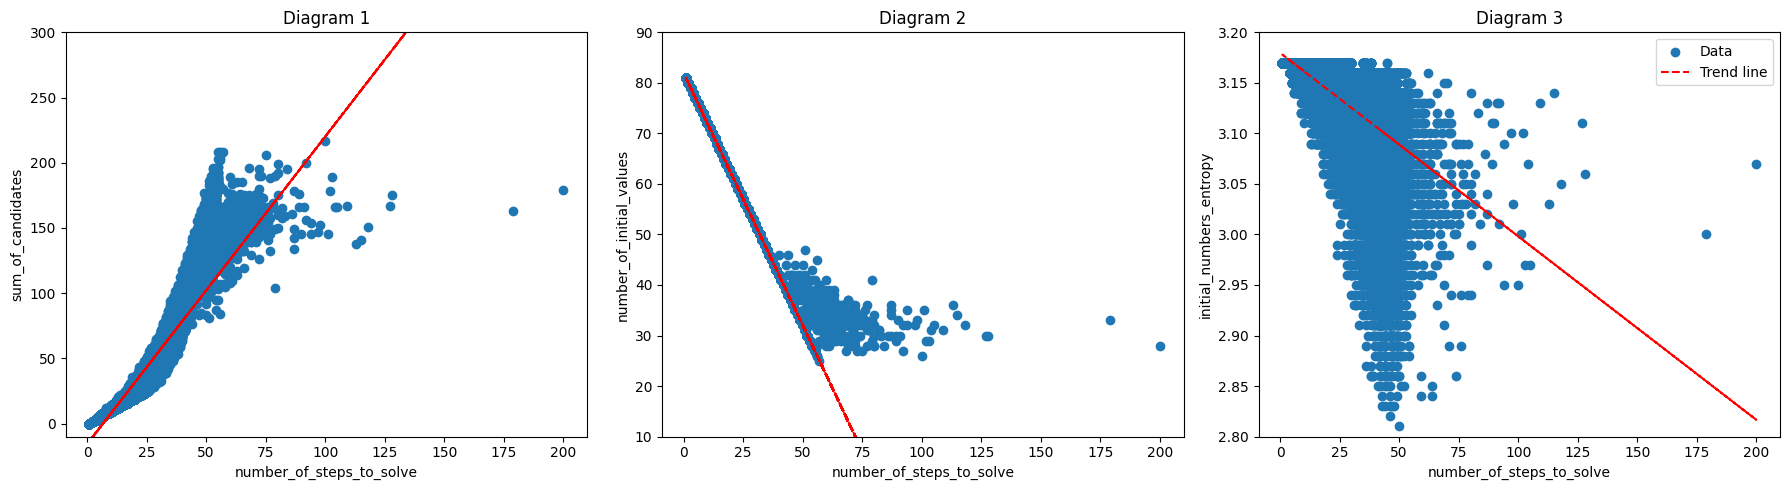

In [6]:
plt.figure(figsize=(18, 5))

columns = ['sum_of_candidates', 'number_of_initial_values', 'initial_numbers_entropy']

for i, column in enumerate(columns, 1):
    x = df_filtered['number_of_steps_to_solve']
    y = df_filtered[column]
    
    plt.subplot(1, 3, i)
    plt.scatter(x, y, label='Data')
    
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--", label='Trend line')
    
    plt.title(f'Diagram {i}')
    plt.xlabel('number_of_steps_to_solve')
    plt.ylabel(column)
    ax = plt.gca()
    
    if i == 1:
        ax.set_ylim([-10, 300])
    elif i == 2:
        ax.set_ylim([10, 90])
    else:
        ax.set_ylim([2.8, 3.2])


plt.tight_layout()
plt.legend()
plt.show()

## Distribution of grids based on number of initial values, splitted into valid and invalid grids (plot)

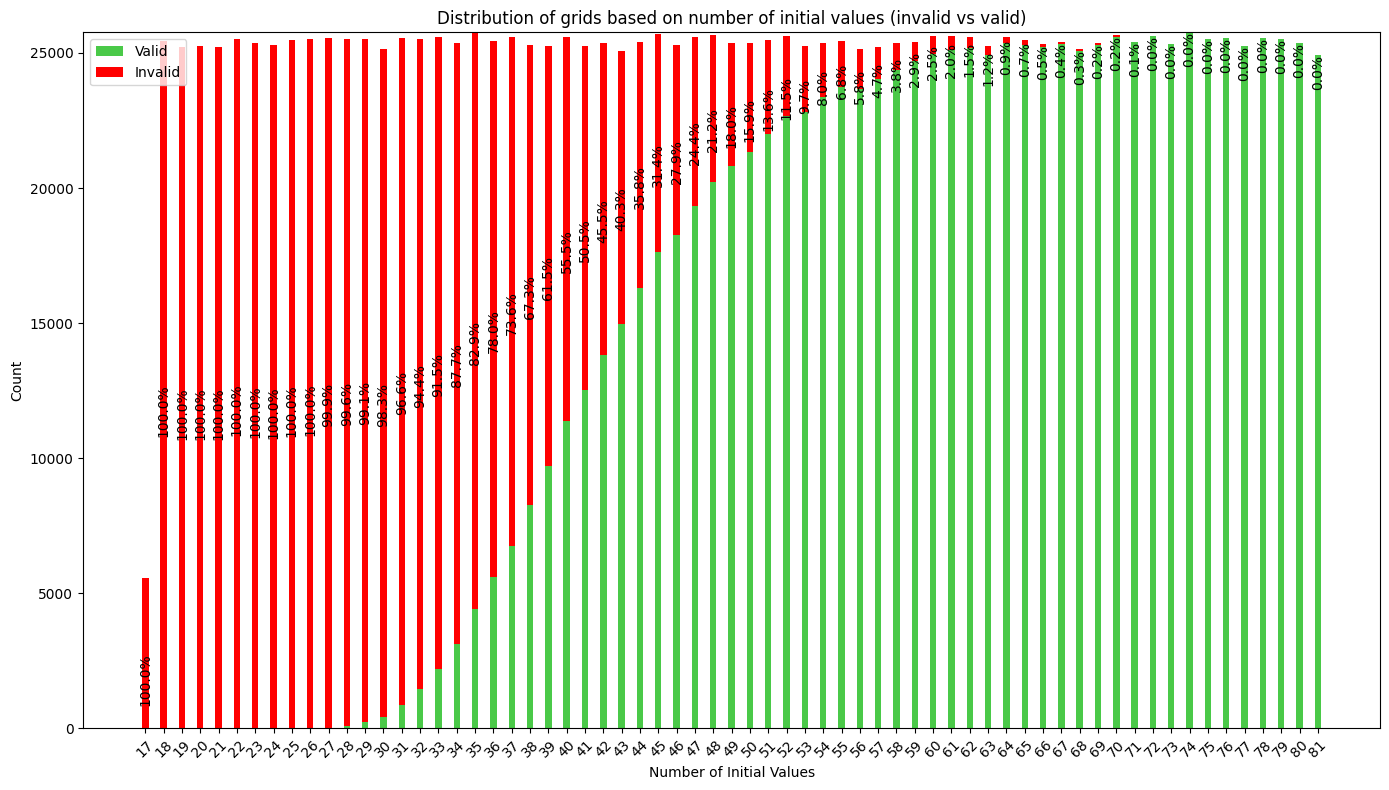

In [7]:
df['is_valid'] = df['number_of_steps_to_solve'] != -1

grouped = df.groupby('number_of_initial_values').agg(
    total_count=('number_of_initial_values', 'size'),
    valid_count=('is_valid', 'sum')
).reset_index()

grouped['invalid_count'] = grouped['total_count'] - grouped['valid_count']

grouped['invalid_percentage'] = (grouped['invalid_count'] / grouped['total_count']) * 100


plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(grouped['number_of_initial_values']))

bars_valid = plt.bar(index, grouped['valid_count'], bar_width, label='Valid', color='#4AC948')
bars_invalid = plt.bar(index, grouped['invalid_count'], bar_width, bottom=grouped['valid_count'], label='Invalid', color='red')

plt.xlabel('Number of Initial Values')
plt.ylabel('Count')
plt.title('Distribution of grids based on number of initial values (invalid vs valid)')
plt.xticks(index, grouped['number_of_initial_values'].astype(str), rotation=45)
plt.legend()

for idx, rect in enumerate(bars_invalid):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., grouped['valid_count'].iloc[idx] + height/2,
             '{:.1f}%'.format(grouped['invalid_percentage'].iloc[idx]),
             ha='center', va='top', color='black', rotation=90)

plt.tight_layout()
plt.show()

## Distribution of grids based on sum of candidates, splitted into valid and invalid grids (plot)

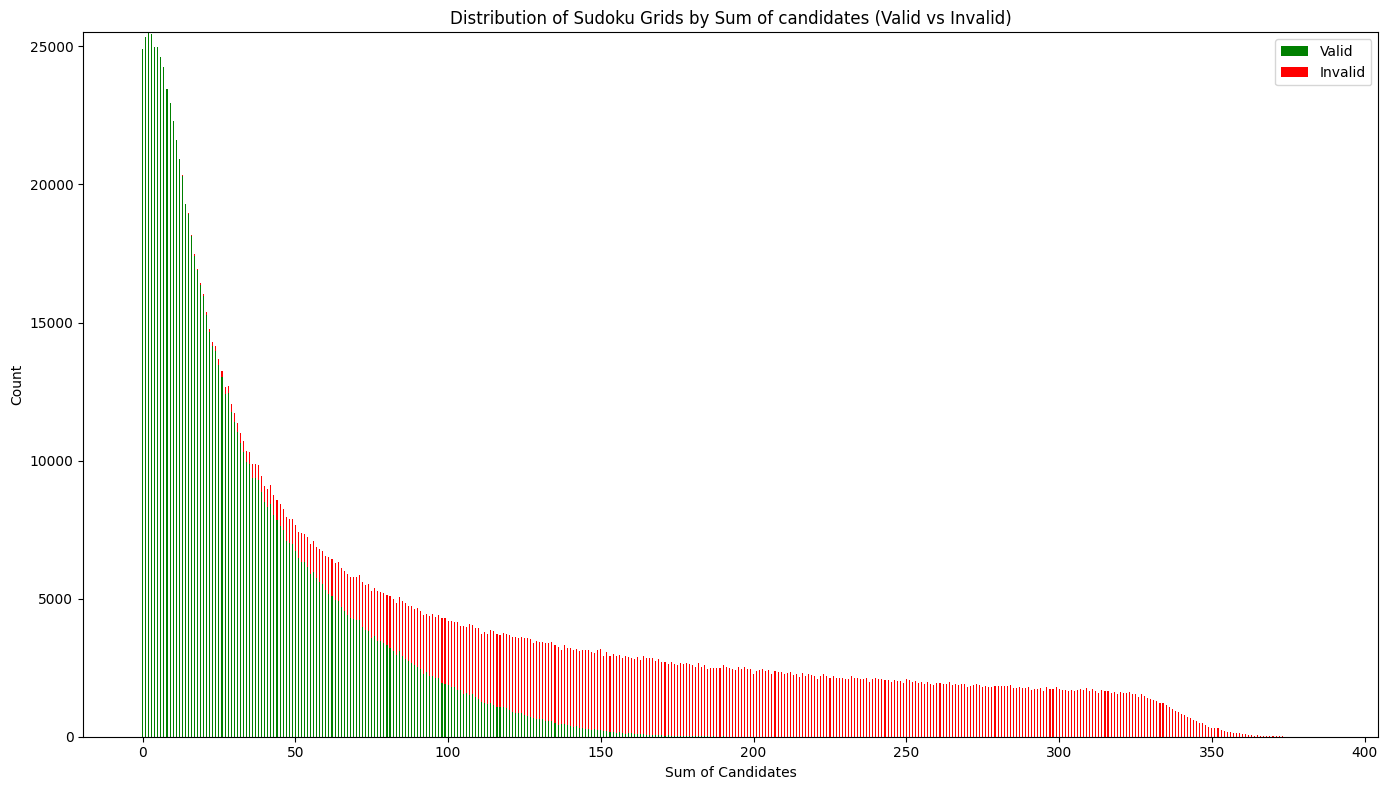

In [8]:
grouped = df.groupby('sum_of_candidates').agg(
    total_count=('sum_of_candidates', 'size'),
    valid_count=('is_valid', 'sum')
).reset_index()

grouped['invalid_count'] = grouped['total_count'] - grouped['valid_count']

plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(grouped['sum_of_candidates']))

bars_valid = plt.bar(index, grouped['valid_count'], bar_width, label='Valid', color='green')
bars_invalid = plt.bar(index, grouped['invalid_count'], bar_width, bottom=grouped['valid_count'], label='Invalid', color='red')

plt.xlabel('Sum of Candidates')
plt.ylabel('Count')
plt.title('Distribution of Sudoku Grids by Sum of candidates (Valid vs Invalid)')
plt.legend()

plt.tight_layout()
plt.show()

## Value of number_of_initial_values up to which the relation between this column and number of steps to solve is perfectly linear

In [9]:
df_filtered[df_filtered['number_of_initial_values'] == 81]["number_of_steps_to_solve"].max()

for i in range(81, 0, -1):
    tmp = df_filtered[df_filtered['number_of_initial_values'] == i]["number_of_steps_to_solve"]
    if  tmp.min() != tmp.max():
        print(i)
        break

47


## Valid grids grouped by number_of_initial_values to show their count

In [11]:
df_filtered.groupby("number_of_initial_values").count()['number_of_steps_to_solve']

number_of_initial_values
25        1
26        4
27       27
28       94
29      231
30      429
31      859
32     1437
33     2178
34     3126
35     4398
36     5595
37     6766
38     8257
39     9713
40    11387
41    12515
42    13830
43    14979
44    16311
45    17628
46    18258
47    19348
48    20238
49    20805
50    21330
51    22001
52    22684
53    22796
54    23353
55    23736
56    23678
57    24044
58    24387
59    24690
60    24966
61    25101
62    25199
63    24938
64    25370
65    25305
66    25215
67    25324
68    25086
69    25312
70    25607
71    25397
72    25609
73    25315
74    25763
75    25513
76    25561
77    25249
78    25558
79    25510
80    25356
81    24913
Name: number_of_steps_to_solve, dtype: int64

In [7]:
df[['sudoku', 'number_of_steps_to_solve']]

,sudoku,number_of_steps_to_solve
0,8651297437930640522417350864709168353195406276...,10
1,5493627187368192452817453966245839718932716541...,-1
2,2874361591659783243942157688325479167163895424...,-1
3,1693478522536897147482516394127385963859621406...,2
4,7163042580540689308307526043470165826004001790...,24
...,...,...
1632862,7652043810896052742018735604925807131763400520...,15
1632863,6457009081298057300001090422900530040802170097...,37
1632864,7360094051204350800547002399080200713600009205...,30
1632865,4680197059138502060270040000000305048500903673...,33
